<i>Updated 27/Nov/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />


# Wasserstein Generative Adversarial Network with Gradient Penalty for CelebA dataset with Tensorflow 2 on Google Colab (WGAN-GP)

Train Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP) on CelebA dataset.

## CelebA データセットに対して Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP) をGoogle Colab 上の Tensorflow 2 で学習する

CelebA データセットに対して Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP) を学習する。




In [1]:
#! pip install tensorflow==2.7.0

In [2]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

2.7.0


# Check the Google Colab runtime environment

## Google Colab 実行環境を調べる

In [3]:
! nvidia-smi
! cat /proc/cpuinfo
! cat /etc/issue
! free -h

Sat Nov 27 16:54:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive from Google Colab

## Google Colab から GoogleDrive をマウントする

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
! ls /content/drive

MyDrive  Shareddrives


# Download source file from Google Drive or nw.tsuda.ac.jp

Basically, <code>gdown</code> from Google Drive.
Download from nw.tsuda.ac.jp above only if the specifications of Google Drive change and you cannot download from Google Drive.

# Google Drive または nw.tsuda.ac.jp からファイルをダウンロードする

基本的に、Google Drive から <code>gdown</code> してください。
Google Drive の仕様が変わってダウンロードができない場合にのみ、nw.tsuda.ac.jp からダウンロードしてください。

In [6]:
# Download source file
nw_path = './nw'
! rm -rf {nw_path}
! mkdir -p {nw_path}

if True:   # from Google Drive
    url_model =  'https://drive.google.com/uc?id=1aBMpQCSfvt-LuR0Is5syyRTXQ79iNh2T'
    ! (cd {nw_path}; gdown {url_model})
else:      # from nw.tsuda.ac.jp
    URL_NW = 'https://nw.tsuda.ac.jp/lec/GoogleColab/pub'
    url_model = f'{URL_NW}/models/WGANGP.py'
    ! wget -nd {url_model} -P {nw_path}

Downloading...
From: https://drive.google.com/uc?id=1aBMpQCSfvt-LuR0Is5syyRTXQ79iNh2T
To: /content/nw/WGANGP.py
100% 19.7k/19.7k [00:00<00:00, 17.3MB/s]


In [7]:
! cat {nw_path}/WGANGP.py

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from functools import partial

import matplotlib.pyplot as plt

import os
import pickle as pkl
import datetime


def grad(y,x):
    V = tf.keras.layers.Lambda(
        lambda z: tf.keras.backend.gradients(z[0],z[1]),
        output_shape=[1]
        )([y,x])
    return V


class RandomWeightedAverage(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    '''Provides a (random) weighted average between real and generated image samples'''
    def call(self, inputs):
        alpha = tf.keras.backend.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])


class WGANGP():
    def __init__(
        self,
        input_dim,
        critic_conv_filters,
        critic_conv_kernel_size,
        critic_conv_strides,
        critic_batch_norm_momentum,
        critic_activation,
        criti

# Preparing CelebA dataset

Official WWW of CelebA dataset: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

Google Drive of CelebA dataset: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg

img_align_celeba.zip mirrored on my Google Drive:
https://drive.google.com/uc?id=1LFKeoI-hb96jlV0K10dO1o04iQPBoFdx

## CelebA データセットを用意する

CelebA データセットの公式ページ: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

CelebA データセットのGoogle Drive: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg

自分の Google Drive 上にミラーした img_align_celeba.zip:
https://drive.google.com/uc?id=1LFKeoI-hb96jlV0K10dO1o04iQPBoFdx

In [8]:
# Download img_align_celeba.zip from GoogleDrive

MIRRORED_URL = 'https://drive.google.com/uc?id=1LFKeoI-hb96jlV0K10dO1o04iQPBoFdx'

! gdown {MIRRORED_URL}

Downloading...
From: https://drive.google.com/uc?id=1LFKeoI-hb96jlV0K10dO1o04iQPBoFdx
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:06<00:00, 211MB/s]


In [9]:
# function to select all images with the specified label
# 指定したラベルの画像を全て選び出す関数

def choose_images(xs, ys, label):
    mask = ys.squeeze() == label
    return xs[mask]

In [10]:
! ls -l img_align_celeba.zip

-rw-r--r-- 1 root root 1443490838 Nov 27 16:55 img_align_celeba.zip


In [11]:
DATA_DIR = 'data'
DATA_SUBDIR = 'img_align_celeba'

In [12]:
! rm -rf {DATA_DIR}
! unzip -d {DATA_DIR} -q {DATA_SUBDIR}.zip

In [13]:
! ls -l {DATA_DIR}/{DATA_SUBDIR} | head
! ls {DATA_DIR}/{DATA_SUBDIR} | wc

total 1737936
-rw-r--r-- 1 root root 11440 Sep 28  2015 000001.jpg
-rw-r--r-- 1 root root  7448 Sep 28  2015 000002.jpg
-rw-r--r-- 1 root root  4253 Sep 28  2015 000003.jpg
-rw-r--r-- 1 root root 10747 Sep 28  2015 000004.jpg
-rw-r--r-- 1 root root  6351 Sep 28  2015 000005.jpg
-rw-r--r-- 1 root root  8073 Sep 28  2015 000006.jpg
-rw-r--r-- 1 root root  8203 Sep 28  2015 000007.jpg
-rw-r--r-- 1 root root  7725 Sep 28  2015 000008.jpg
-rw-r--r-- 1 root root  8641 Sep 28  2015 000009.jpg
 202599  202599 2228589


# Check the CelebA dataset

## CelebA データセットを確認する


In [14]:
# paths to all the image files.

import os
import glob
import numpy as np

all_file_paths = np.array(glob.glob(os.path.join(DATA_DIR, DATA_SUBDIR, '*.jpg')))
n_all_images = len(all_file_paths)

print(n_all_images)

202599


In [15]:
# slect some image files.

n_to_show = 10
selected_indices = np.random.choice(range(n_all_images), n_to_show)
selected_paths = all_file_paths[selected_indices]

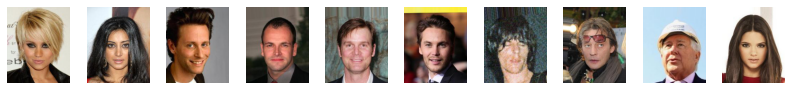

In [16]:
# Display some images.
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, n_to_show, figsize=(1.4 * n_to_show, 1.4))
for i, path in enumerate(selected_paths):
    img = tf.keras.preprocessing.image.load_img(path)
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

# Separate image files for train and test

## 画像ファイルを学習用とテスト用に分割する

In [17]:
TRAIN_DATA_DIR = 'train_data'
TEST_DATA_DIR = 'test_data'

In [18]:
import os

split = 0.05

indices = np.arange(n_all_images)
np.random.shuffle(indices)
train_indices = indices[: -int(n_all_images * split)]
test_indices = indices[-int(n_all_images * split):]

! rm -rf {TRAIN_DATA_DIR} {TEST_DATA_DIR}

dst=f'{TRAIN_DATA_DIR}/celeba'
if not os.path.exists(dst):
    os.makedirs(dst)
for idx in train_indices:
    path = all_file_paths[idx]
    dpath, fname = os.path.split(path)
    os.symlink(f'../../{path}', f'{dst}/{fname}')

dst=f'{TEST_DATA_DIR}/celeba'
if not os.path.exists(dst):
    os.makedirs(dst)
for idx in test_indices:
    path = all_file_paths[idx]
    dpath, fname = os.path.split(path)
    os.symlink(f'../../{path}', f'{dst}/{fname}')

# Prepare ImageDataGenerator

<code>flow_from_directory()</code> requires to specify the parent directory of the directory where the image files are located.

## ImageDataGenerator を用意する

<code>flow_from_directory()</code> では image files があるディレクトリの親ディレクトリを指定する必要がある。

In [19]:
IMAGE_SIZE = 64
BATCH_SIZE = 64

In [20]:
INPUT_DIM = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [21]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = lambda x: (x.astype('float32') - 127.5) / 127.5
    )

data_flow = data_gen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle=True,
    class_mode = 'input'
    )

val_data_flow = data_gen.flow_from_directory(
    TEST_DATA_DIR,
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle=True,
    class_mode = 'input'
    )

Found 192470 images belonging to 1 classes.
Found 10129 images belonging to 1 classes.


In [22]:
print(len(data_flow))
print(len(val_data_flow))

3008
159


(64, 64, 3)


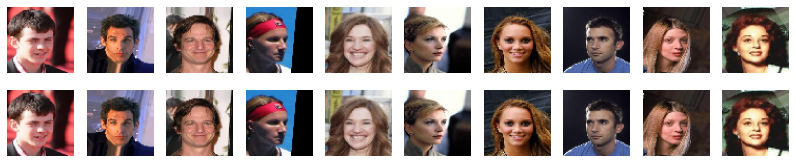

In [23]:
# ImageDataGenerator.next() returns the same x and y when class_mode='input'
x, y = next(data_flow)
print(x[0].shape)

x = (x + 1) * 0.5      # [-1, 1] --> [0, 1]
x = np.clip(x, 0, 1)

y = (y + 1) * 0.5      # [-1, 1] --> [0, 1]
y = np.clip(y, 0, 1)

%matplotlib inline
import matplotlib.pyplot as plt

n_to_show = 10
fig, ax = plt.subplots(2, n_to_show, figsize=(1.4 * n_to_show, 1.4 * 2))
for i in range(n_to_show):
    ax[0][i].imshow(x[i])
    ax[0][i].axis('off')
    ax[1][i].imshow(y[i])
    ax[1][i].axis('off')
plt.show()

# Define the Neural Network Model

## ニューラルネットワーク・モデルを定義する

In [24]:
from nw.WGANGP import WGANGP

gan = WGANGP(
    input_dim = (IMAGE_SIZE, IMAGE_SIZE, 3),
    critic_conv_filters = [64, 128, 256, 512],
    critic_conv_kernel_size = [5,5,5,5],
    critic_conv_strides = [2,2,2,2],
    critic_batch_norm_momentum = None,
    critic_activation = 'leaky_relu',
    critic_dropout_rate = None,
    critic_learning_rate = 0.0002,
    generator_initial_dense_layer_size = (4,4,512),
    generator_upsample = [1,1,1,1],
    generator_conv_filters = [256, 128, 64, 3],
    generator_conv_kernel_size = [5,5,5,5],
    generator_conv_strides = [2,2,2,2],
    generator_batch_norm_momentum = 0.9,
    generator_activation = 'leaky_relu',
    generator_dropout_rate = None,
    generator_learning_rate = 0.0002,
    optimizer = 'adam',
    grad_weight = 10,
    z_dim = 100, 
    batch_size = BATCH_SIZE
)

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
gan.critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 critic_conv_0 (Conv2D)      multiple                  4864      
                                                                 
 leaky_re_lu (LeakyReLU)     multiple                  0         
                                                                 
 critic_conv_1 (Conv2D)      multiple                  204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   multiple                  0         
                                                                 
 critic_conv_2 (Conv2D)      multiple                  819456    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   multiple                  0     

In [26]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 generator_conv_0 (Conv2DTra  (None, 8, 8, 256)        3277

In [27]:
gan.critic_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f4bd7f350d0>>

In [28]:
gan.model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_1 (Functional)        (None, 64, 64, 3)         5168003   
                                                                 
 model (Functional)          (None, 1)                 4314753   
                                                                 
Total params: 5,168,003
Trainable params: 5,150,723
Non-trainable params: 17,280
_________________________________________________________________


# Training

## 学習

# At first, try training a small number of epoch.

## まず、少ない回数だけ学習してみる


In [29]:
save_path1 = '/content/drive/MyDrive/ColabRun/WGANGP_CelebA01'

In [30]:
gan.train(
    data_flow,
    batch_size = BATCH_SIZE,
    epochs = 3,
    run_folder = save_path1,
    using_generator=True
)

1 (5, 1) [D loss: -1.452 R -6.831 F 0.076 G 0.530][G loss: -5.111]  0:00:08.568548
2 (5, 1) [D loss: -94.698 R -154.039 F 1.674 G 5.767][G loss: -59.722]  0:00:09.578428
3 (5, 1) [D loss: -125.352 R -212.060 F 2.328 G 8.438][G loss: -60.217]  0:00:10.445299


In [31]:
print(gan.epoch)

3


In [32]:
print(gan.d_losses[:3])

[[-1.4522681, -6.8312173, 0.07562452, 0.53033245], [-94.69839, -154.03935, 1.6740208, 5.766694], [-125.35213, -212.05988, 2.3275084, 8.438024]]


In [33]:
print(gan.g_losses[:3])

[-5.111105, -59.721878, -60.21668]


In [34]:
# Train the model a little more
# もう少し学習を進めてみる

gan.train(
    data_flow,
    batch_size = BATCH_SIZE,
    epochs = 10,
    run_folder = save_path1,
    using_generator=True
)

4 (5, 1) [D loss: -134.797 R -224.033 F 3.421 G 8.582][G loss: -70.592]  0:00:00.907660
5 (5, 1) [D loss: -141.399 R -220.096 F 4.467 G 7.423][G loss: -79.711]  0:00:01.781655
6 (5, 1) [D loss: -146.432 R -237.543 F 6.248 G 8.486][G loss: -79.515]  0:00:02.637618
7 (5, 1) [D loss: -134.878 R -256.607 F 10.219 G 11.151][G loss: -55.759]  0:00:03.697741
8 (5, 1) [D loss: -137.791 R -229.810 F 10.002 G 8.202][G loss: -89.419]  0:00:04.555707
9 (5, 1) [D loss: -152.717 R -255.131 F 14.374 G 8.804][G loss: -83.649]  0:00:05.414939
10 (5, 1) [D loss: -136.168 R -208.047 F 12.359 G 5.952][G loss: -79.789]  0:00:06.262849


# Check the loss and accuracy of the training process.

## 学習過程のlossと精度を確認する

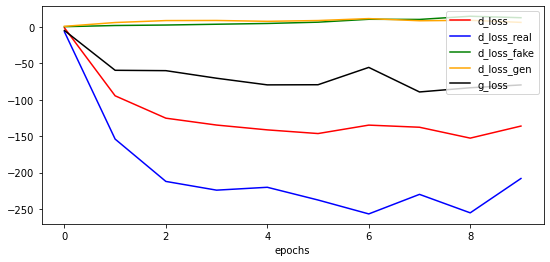

In [35]:
# Display the graph of losses in training
%matplotlib inline

gan.showLoss()

# Check the saved files

## 保存されているファイルを確認する

In [36]:
! ls -lR {save_path1}

/content/drive/MyDrive/ColabRun/WGANGP_CelebA01:
total 8
-rw------- 1 root root 1239 Nov 27 16:56 params_10.pkl
-rw------- 1 root root  574 Nov 27 16:56 params_3.pkl
-rw------- 1 root root 1239 Nov 27 16:56 params.pkl
drwx------ 2 root root 4096 Nov 27 16:56 weights

/content/drive/MyDrive/ColabRun/WGANGP_CelebA01/weights:
total 222560
-rw------- 1 root root 17285328 Nov 27 16:56 critic-weights_10.h5
-rw------- 1 root root 17285328 Nov 27 16:56 critic-weights_3.h5
-rw------- 1 root root 17285328 Nov 27 16:56 critic-weights.h5
-rw------- 1 root root 20713304 Nov 27 16:56 generator-weights_10.h5
-rw------- 1 root root 20713304 Nov 27 16:56 generator-weights_3.h5
-rw------- 1 root root 20713304 Nov 27 16:56 generator-weights.h5
-rw------- 1 root root 37967552 Nov 27 16:56 weights_10.h5
-rw------- 1 root root 37967552 Nov 27 16:56 weights_3.h5
-rw------- 1 root root 37967552 Nov 27 16:56 weights.h5


# Load the saved file and try further training.

Load the saved parameters and model weights, and try training further.

## セーブしたファイルをロードして、さらに学習を進める

保存してあるパラメータとモデルの重みをロードして、追加の学習を試みる。

In [37]:
# Load the saved parameters and weights.
# 保存してある学習結果をロードする。

gan_work = WGANGP.load(save_path1)

# Display the epoch count of the model.
# training のepoch回数を表示する。

print(gan_work.epoch)

10


In [38]:
# Training in addition
# 追加で training する。

gan_work.train(
    data_flow,
    batch_size = BATCH_SIZE,
    epochs = 100,
    run_folder = save_path1,
    using_generator = True
)

11 (5, 1) [D loss: -145.111 R -230.313 F 16.396 G 6.881][G loss: -73.390]  0:00:04.370944
12 (5, 1) [D loss: -126.598 R -256.478 F 22.593 G 10.729][G loss: -62.728]  0:00:05.238850
13 (5, 1) [D loss: -135.129 R -238.813 F 20.494 G 8.319][G loss: -71.997]  0:00:06.113300
14 (5, 1) [D loss: -134.017 R -263.914 F 30.675 G 9.922][G loss: -47.495]  0:00:06.969948
15 (5, 1) [D loss: -145.220 R -256.435 F 27.660 G 8.356][G loss: -60.498]  0:00:07.813600
16 (5, 1) [D loss: -129.393 R -261.882 F 33.008 G 9.948][G loss: -41.802]  0:00:08.676386
17 (5, 1) [D loss: -138.552 R -237.740 F 22.880 G 7.631][G loss: -72.241]  0:00:09.521888
18 (5, 1) [D loss: -125.650 R -218.664 F 26.244 G 6.677][G loss: -71.150]  0:00:10.368980
19 (5, 1) [D loss: -133.469 R -245.930 F 39.784 G 7.268][G loss: -51.895]  0:00:11.218729
20 (5, 1) [D loss: -120.972 R -319.283 F 20.084 G 17.823][G loss: -70.760]  0:00:12.070377
21 (5, 1) [D loss: -144.967 R -239.862 F 33.331 G 6.156][G loss: -58.721]  0:00:12.920787
22 (5, 1

In [39]:
%matplotlib inline 

# prepare the noise vectors
# ノイズ・ベクトルを用意する。

if False:
    rows, cols = 5, 5

    noise = np.random.normal(0, 1, (rows * cols, gan.z_dim))

    imgs = gan_work.generator.predict(noise)
    imgs = 0.5 * (imgs + 1)
    imgs = np.clip(imgs, 0, 1)
    #imgs = gan.generate_images(noise).squeeze()
    WGANGP.showImages(imgs, rows, cols, 1.4, 1.4)

In [40]:
# Training in addition
# 追加で training する。

gan_work.train(
    data_flow,
    batch_size = BATCH_SIZE,
    epochs = 500,
    run_folder = save_path1,
    print_every_n_batches = 2000,
    using_generator = True
)

101 (5, 1) [D loss: -49.996 R -98.056 F 25.117 G 2.294][G loss: -85.479]  0:00:00.896998
102 (5, 1) [D loss: -33.155 R -134.270 F 86.224 G 1.489][G loss: -101.347]  0:00:01.776530
103 (5, 1) [D loss: -40.341 R -129.443 F 70.217 G 1.888][G loss: -69.009]  0:00:02.663597
104 (5, 1) [D loss: -64.789 R -126.148 F 37.323 G 2.404][G loss: -137.173]  0:00:03.531095
105 (5, 1) [D loss: -49.857 R -127.659 F 59.476 G 1.833][G loss: -139.740]  0:00:04.387218
106 (5, 1) [D loss: -52.822 R -172.850 F 96.998 G 2.303][G loss: -138.717]  0:00:05.277584
107 (5, 1) [D loss: -61.973 R -179.439 F 92.783 G 2.468][G loss: -162.949]  0:00:06.151385
108 (5, 1) [D loss: -63.311 R -171.376 F 74.219 G 3.385][G loss: -162.178]  0:00:07.188435
109 (5, 1) [D loss: -51.003 R -167.492 F 97.332 G 1.916][G loss: -117.401]  0:00:08.144431
110 (5, 1) [D loss: -45.899 R -159.672 F 92.270 G 2.150][G loss: -111.124]  0:00:09.011090
111 (5, 1) [D loss: -44.189 R -136.465 F 71.075 G 2.120][G loss: -114.546]  0:00:09.876777
11

In [41]:
# Training in addition
# 追加で training する。

gan_work.train(
    data_flow,
    batch_size = BATCH_SIZE,
    epochs = 1000,
    run_folder = save_path1,
    print_every_n_batches = 2000,
    using_generator = True
)

501 (5, 1) [D loss: -43.299 R 63.570 F -135.909 G 2.904][G loss: 66.481]  0:00:00.969720
502 (5, 1) [D loss: -43.223 R 35.855 F -109.093 G 3.002][G loss: 50.818]  0:00:01.923749
503 (5, 1) [D loss: -61.672 R 39.319 F -132.954 G 3.196][G loss: 51.177]  0:00:02.897205
504 (5, 1) [D loss: -44.974 R -8.825 F -44.407 G 0.826][G loss: 44.047]  0:00:04.087767
505 (5, 1) [D loss: -33.108 R 9.795 F -51.938 G 0.903][G loss: 64.168]  0:00:05.047283
506 (5, 1) [D loss: -41.600 R -46.524 F -7.684 G 1.261][G loss: 16.457]  0:00:06.003518
507 (5, 1) [D loss: -42.538 R -28.090 F -26.310 G 1.186][G loss: 19.883]  0:00:06.956091
508 (5, 1) [D loss: -30.591 R -30.930 F -13.543 G 1.388][G loss: -8.632]  0:00:07.927215
509 (5, 1) [D loss: -28.020 R -48.064 F 9.862 G 1.018][G loss: -17.795]  0:00:09.070329
510 (5, 1) [D loss: -38.337 R -51.344 F 2.887 G 1.012][G loss: 14.404]  0:00:10.040942
511 (5, 1) [D loss: -36.400 R -40.089 F -10.409 G 1.410][G loss: 8.019]  0:00:10.984342
512 (5, 1) [D loss: -32.429 R

In [42]:
# Training in addition
# 追加で training する。

gan_work.train(
    data_flow,
    batch_size = BATCH_SIZE,
    epochs = 6000,
    run_folder = save_path1,
    print_every_n_batches = 2000,
    using_generator = True
)

1001 (5, 1) [D loss: -34.160 R -253.075 F 202.181 G 1.673][G loss: -221.984]  0:00:00.850222
1002 (5, 1) [D loss: -23.337 R -264.218 F 235.694 G 0.519][G loss: -229.298]  0:00:01.714649
1003 (5, 1) [D loss: -26.666 R -234.612 F 199.319 G 0.863][G loss: -200.731]  0:00:02.566652
1004 (5, 1) [D loss: -28.621 R -229.981 F 194.607 G 0.675][G loss: -195.755]  0:00:03.616948
1005 (5, 1) [D loss: -22.541 R -257.497 F 227.861 G 0.709][G loss: -212.452]  0:00:04.473033
1006 (5, 1) [D loss: -23.314 R -242.337 F 211.859 G 0.716][G loss: -215.902]  0:00:05.326734
1007 (5, 1) [D loss: -18.562 R -134.019 F 104.429 G 1.103][G loss: -103.327]  0:00:06.171406
1008 (5, 1) [D loss: -21.065 R -148.791 F 123.580 G 0.415][G loss: -105.166]  0:00:07.016568
1009 (5, 1) [D loss: -24.632 R -160.066 F 129.658 G 0.578][G loss: -136.224]  0:00:07.863141
1010 (5, 1) [D loss: -24.875 R -120.810 F 87.501 G 0.843][G loss: -93.962]  0:00:08.904432
1011 (5, 1) [D loss: -21.061 R -120.793 F 91.923 G 0.781][G loss: -69.31

In [43]:
# Training in addition
# 追加で training する。

gan_work.train(
    data_flow,
    batch_size = BATCH_SIZE,
    epochs = 30000,
    run_folder = save_path1,
    print_every_n_batches = 6000,
    using_generator = True
)

ストリーミング出力は最後の 5000 行に切り捨てられました。
25001 (5, 1) [D loss: -7.160 R 37.465 F -45.798 G 0.117][G loss: 44.991]  4:15:15.701318
25002 (5, 1) [D loss: -10.479 R 35.978 F -47.200 G 0.074][G loss: 51.749]  4:15:16.496347
25003 (5, 1) [D loss: -8.428 R 38.903 F -47.978 G 0.065][G loss: 45.188]  4:15:17.295443
25004 (5, 1) [D loss: -5.834 R 41.982 F -48.611 G 0.080][G loss: 47.524]  4:15:18.092764
25005 (5, 1) [D loss: -8.982 R 51.531 F -61.439 G 0.093][G loss: 59.447]  4:15:18.909976
25006 (5, 1) [D loss: -7.505 R 53.878 F -62.393 G 0.101][G loss: 62.895]  4:15:19.706421
25007 (5, 1) [D loss: -8.268 R 54.391 F -63.445 G 0.079][G loss: 58.079]  4:15:20.525701
25008 (5, 1) [D loss: -4.793 R 49.192 F -54.665 G 0.068][G loss: 52.412]  4:15:21.324829
25009 (5, 1) [D loss: -12.914 R 42.186 F -56.001 G 0.090][G loss: 50.300]  4:15:22.115290
25010 (5, 1) [D loss: -3.550 R 51.561 F -55.765 G 0.065][G loss: 50.636]  4:15:22.920583
25011 (5, 1) [D loss: -5.798 R 37.847 F -44.310 G 0.067][G loss: 41.284]  4:

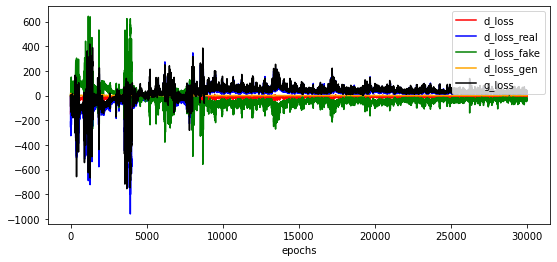

In [44]:
# Display the graph of losses in training
%matplotlib inline

gan_work.showLoss()

# Generate Images from 100-dimensional noise vector and select original images similar to each.

# 100次元のノイズ・ベクトルから画像を生成してみる。

In [45]:
# prepare the noise vectors
# ノイズ・ベクトルを用意する。

rows, cols = 2, 10

noise = np.random.normal(0, 1, (rows * cols, gan_work.z_dim))

In [46]:
! ls -lR {save_path1}

/content/drive/MyDrive/ColabRun/WGANGP_CelebA01:
total 17825
-rw------- 1 root root  142585 Nov 27 17:11 params_1000.pkl
-rw------- 1 root root   13884 Nov 27 16:57 params_100.pkl
-rw------- 1 root root    1239 Nov 27 16:56 params_10.pkl
-rw------- 1 root root 1715629 Nov 27 19:40 params_12000.pkl
-rw------- 1 root root 2573653 Nov 27 21:00 params_18000.pkl
-rw------- 1 root root  285589 Nov 27 17:25 params_2000.pkl
-rw------- 1 root root 3431677 Nov 27 22:21 params_24000.pkl
-rw------- 1 root root 4289701 Nov 27 23:41 params_30000.pkl
-rw------- 1 root root     574 Nov 27 16:56 params_3.pkl
-rw------- 1 root root  571597 Nov 27 17:52 params_4000.pkl
-rw------- 1 root root   71085 Nov 27 17:03 params_500.pkl
-rw------- 1 root root  857605 Nov 27 18:19 params_6000.pkl
-rw------- 1 root root 4289701 Nov 27 23:41 params.pkl
drwx------ 2 root root    4096 Nov 27 23:41 weights

/content/drive/MyDrive/ColabRun/WGANGP_CelebA01/weights:
total 964430
-rw------- 1 root root 17285368 Nov 27 17:11

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


epoch 3


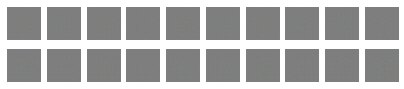

epoch 10


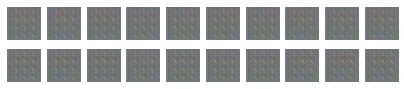

epoch 100


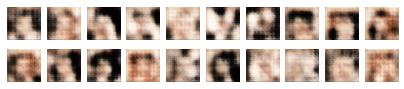

epoch 500


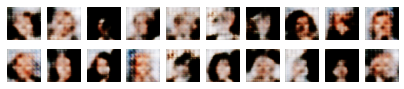

epoch 1000


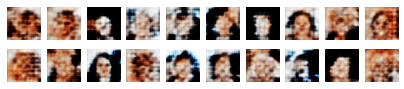

epoch 2000


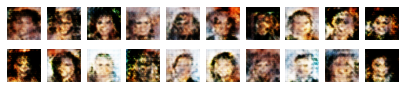

epoch 4000


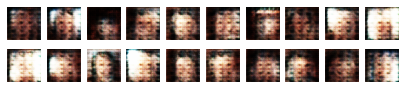

epoch 6000


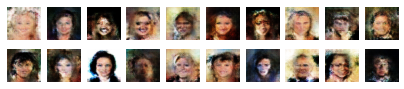

In [47]:
%matplotlib inline

for i in [3, 10, 100, 500, 1000, 2000, 4000, 6000, 12000, 18000, 24000, 30000]:
    gan = WGANGP.load(save_path1, i)
    imgs = gan.generate_images(noise).squeeze()
    print(f'epoch {i}')
    WGANGP.showImages(imgs, rows, cols, 0.7, 0.7)

# Analysis after training

# 学習後の解析

# Function to select the most similar image from the x_train images.

## ある画像に対して、学習用画像の中から最も似た画像を選ぶ関数

In [48]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [49]:
def most_similar(target, data_flow, batch_size):  # data_flow is generator
    target = (target * 2) - 1    # [0, 1] --> [-1, 1]

    d_min = 99999
    img_min = None
    steps = len(data_flow) // batch_size

    for i in range(steps):
        x_, _ = next(data_flow)
        for j, img in enumerate(x_):
            if i == 0 and j == 0:
                d_min = compare_images(target, img)
                img_min = img
            else:
                d = compare_images(target, img)
                if d < d_min:
                    d_min = d
                    img_min = img

    img = (img + 1) * 0.5    # [-1, 1] --> [0, 1]
    img = np.clip(img, 0, 1) 
    return img

# Generate images from 100-dimensional noise vectors and select original images

## 100次元のノイズ・ベクトルから画像を生成し、似ている原画像を選ぶ

In [50]:
# load the most trained model.
# 最も学習が進んだモデルをロードする。

gan = WGANGP.load(save_path1)

In [51]:
n_to_show = 10

# prepare noise vectors
# ノイズ・ベクトルを用意する
noise = np.random.normal(0, 1, (n_to_show, gan.z_dim))   # mean:0, scale=1 --> [-1, 1]

# Generate images from noise vectors.
# ノイズベクトルから画像を生成する
gen_imgs = gan_work.generate_images(noise)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [52]:
# Select the most similar image of x_train to each image generated.
# 生成した各画像に最も似ている x_train の画像を選ぶ

similar_imgs = []
for gen in gen_imgs:
    ori = most_similar(gen, data_flow, BATCH_SIZE)
    similar_imgs.append(ori)

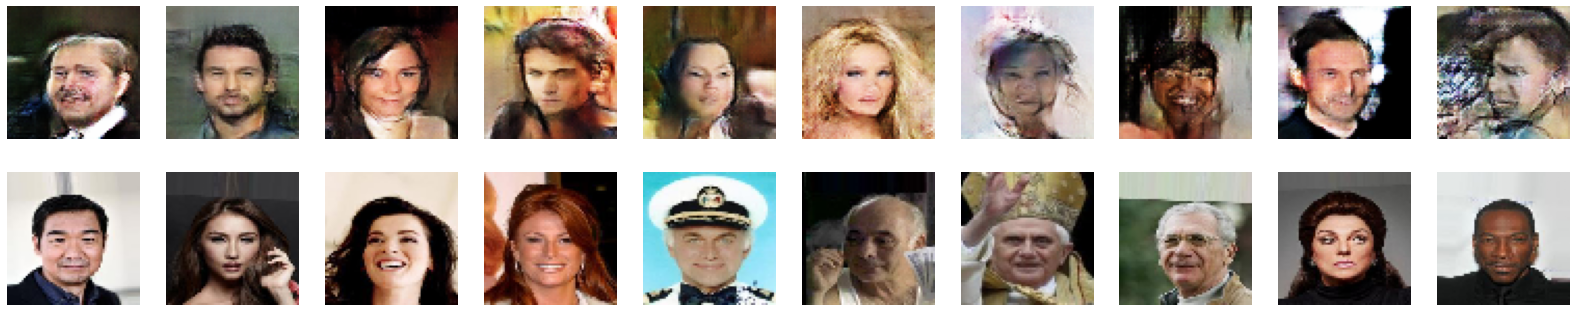

In [53]:
# Display the pairs of generated image and original image.
# 生成画像と、似ている原画像のペアを表示する。

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, n_to_show, figsize=(2.8 * n_to_show, 2.8 * 2))
for i in range(n_to_show):
    ax[0][i].imshow(gen_imgs[i])
    ax[0][i].axis('off')
    ax[1][i].imshow(similar_imgs[i])
    ax[1][i].axis('off')
plt.show()